## Utkarsh Joshi 

### Aim:

######  Understand the impact of input variables as ordinal. Should treating them as numeric or categorical makes any difference in performace

##### Approach:

- Apply numeric vs categorical treatment on data and compute the results.
- Split 80- 20 
- Use 80% for Nested CV and Select the best model for each (Numeric and categorical) based on different metric scores
- I am considering learning curve with accuracy to understand model behaviour 
- Use 80% again for hyperparameter tunning of the best model
- Test 20% on the best model to see if it is generalizing efficiently 




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, label_binarize
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix


C:\Users\91788\AppData\Roaming\Python\Python310\site-packages\scipy\__init__.py:169: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# Function to load dataset
def load_car_evaluation_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
    column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
    car_data = pd.read_csv(url, names=column_names)
    return car_data


car_data = load_car_evaluation_data()
y = car_data["class"]



In [3]:
car_data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
# Ordinal Encoding
car_data_numeric = car_data.copy()
ordinal_mappings = {
    "buying": ["low", "med", "high", "vhigh"],
    "maint": ["low", "med", "high", "vhigh"],
    "doors": ["2", "3", "4", "5more"],
    "persons": ["2", "4", "more"],
    "lug_boot": ["small", "med", "big"],
    "safety": ["low", "med", "high"]
}

ordinal_encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_mappings])
car_data_numeric[list(ordinal_mappings.keys())] = ordinal_encoder.fit_transform(car_data_numeric[list(ordinal_mappings.keys())])


car_data_numeric

,buying,maint,doors,persons,lug_boot,safety,class
0,3.0,3.0,0.0,0.0,0.0,0.0,unacc
1,3.0,3.0,0.0,0.0,0.0,1.0,unacc
2,3.0,3.0,0.0,0.0,0.0,2.0,unacc
3,3.0,3.0,0.0,0.0,1.0,0.0,unacc
4,3.0,3.0,0.0,0.0,1.0,1.0,unacc
...,...,...,...,...,...,...,...
1723,0.0,0.0,3.0,2.0,1.0,1.0,good
1724,0.0,0.0,3.0,2.0,1.0,2.0,vgood
1725,0.0,0.0,3.0,2.0,2.0,0.0,unacc
1726,0.0,0.0,3.0,2.0,2.0,1.0,good


In [5]:
# One-Hot Encoding
car_data_categorical = car_data.copy()
onehot_encoder = OneHotEncoder(drop="first", sparse=False)
encoded_features = onehot_encoder.fit_transform(car_data_categorical[list(ordinal_mappings.keys())])
encoded_feature_names = onehot_encoder.get_feature_names_out(input_features=list(ordinal_mappings.keys()))
car_data_categorical = car_data_categorical.drop(columns=list(ordinal_mappings.keys()))
car_data_categorical = pd.concat([car_data_categorical, pd.DataFrame(encoded_features, columns=encoded_feature_names)], axis=1)

print(car_data_categorical)
# Convert y to numerical values for classification
y_encoded = y.astype("category").cat.codes


      class  buying_low  buying_med  buying_vhigh  maint_low  maint_med  \
0     unacc         0.0         0.0           1.0        0.0        0.0   
1     unacc         0.0         0.0           1.0        0.0        0.0   
2     unacc         0.0         0.0           1.0        0.0        0.0   
3     unacc         0.0         0.0           1.0        0.0        0.0   
4     unacc         0.0         0.0           1.0        0.0        0.0   
...     ...         ...         ...           ...        ...        ...   
1723   good         1.0         0.0           0.0        1.0        0.0   
1724  vgood         1.0         0.0           0.0        1.0        0.0   
1725  unacc         1.0         0.0           0.0        1.0        0.0   
1726   good         1.0         0.0           0.0        1.0        0.0   
1727  vgood         1.0         0.0           0.0        1.0        0.0   

      maint_vhigh  doors_3  doors_4  doors_5more  persons_4  persons_more  \
0             1.0     

In [6]:
# Initial Train-Test Split (80-20)
X_numeric = car_data_numeric.drop(columns=["class"])
X_categorical = car_data_categorical.drop(columns=["class"])

X_train_num, X_test_num, y_train, y_test = train_test_split(X_numeric, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_cat, X_test_cat, _, _ = train_test_split(X_categorical, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define Stratified K-Fold for Nested CV
outer_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Define models and parameters
param_grids = {
    "Decision Tree": {"max_depth": [3, 5, 10, None], "min_samples_split": [2, 5, 10]},
    "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7, 9, 11, 15]},
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10, 100], "solver": ["lbfgs", "liblinear"]},
    "SVM": {"C": [0.01, 0.1, 1, 10, 100], "kernel": ["linear", "rbf", "poly"], "gamma": ["scale", "auto"]}
}

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight="balanced"),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced"),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42, class_weight="balanced")
}

scoring_metrics = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average="weighted"),
    "recall": make_scorer(recall_score, average="weighted"),
    "f1_score": make_scorer(f1_score, average="weighted"),
    "mcc": make_scorer(matthews_corrcoef),
    "roc_auc": make_scorer(roc_auc_score, needs_proba=True, multi_class="ovr")
}



In [7]:
# Nested Cross Validation

def run_nested_cv(X_train, y_train, encoding_type):
    nested_cv_results = {}
    best_models = {}
    for model_name, model in models.items():
        if encoding_type == "Numeric":
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)

        if model_name in param_grids:
            grid_search = GridSearchCV(model, param_grids[model_name], cv=inner_kf, scoring="accuracy", n_jobs=-1)
            scores = cross_validate(grid_search, X_train, y_train, cv=outer_kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
            best_models[model_name] = grid_search
        else:
            scores = cross_validate(model, X_train, y_train, cv=outer_kf, scoring=scoring_metrics, n_jobs=-1, return_train_score=True)
            best_models[model_name] = model

        nested_cv_results[model_name] = {metric: np.mean(scores[f"test_{metric}"]) for metric in scoring_metrics.keys()}

    return nested_cv_results, best_models


numeric_results, numeric_best_models = run_nested_cv(X_train_num, y_train, "Numeric")
categorical_results, categorical_best_models = run_nested_cv(X_train_cat, y_train, "Categorical")

# Results
print("\nNested CV Results (Numeric Features):\n", pd.DataFrame(numeric_results).T)
print("\nNested CV Results (Categorical Features):\n", pd.DataFrame(categorical_results).T)




Nested CV Results (Numeric Features):
                      accuracy  precision    recall  f1_score       mcc  \
Decision Tree        0.973222   0.973521  0.973222  0.973013  0.941262   
K-Nearest Neighbors  0.945022   0.946744  0.945022  0.943626  0.879031   
Logistic Regression  0.829218   0.842748  0.829218  0.831935  0.642308   
Naïve Bayes          0.698271   0.771818  0.698271  0.696206  0.398279   
SVM                  0.981905   0.982431  0.981905  0.981945  0.960715   

                      roc_auc  
Decision Tree        0.966068  
K-Nearest Neighbors  0.985994  
Logistic Regression  0.939644  
Naïve Bayes          0.894409  
SVM                  0.999008  

Nested CV Results (Categorical Features):
                      accuracy  precision    recall  f1_score       mcc  \
Decision Tree        0.882057   0.881660  0.882057  0.880709  0.740323   
K-Nearest Neighbors  0.840106   0.822042  0.840106  0.822499  0.627566   
Logistic Regression  0.929095   0.936601  0.929095  0.930

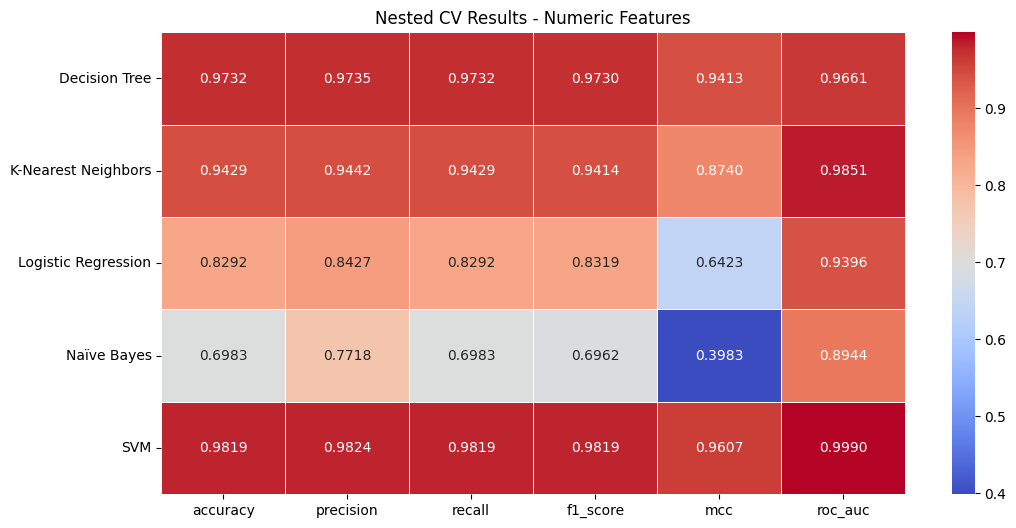

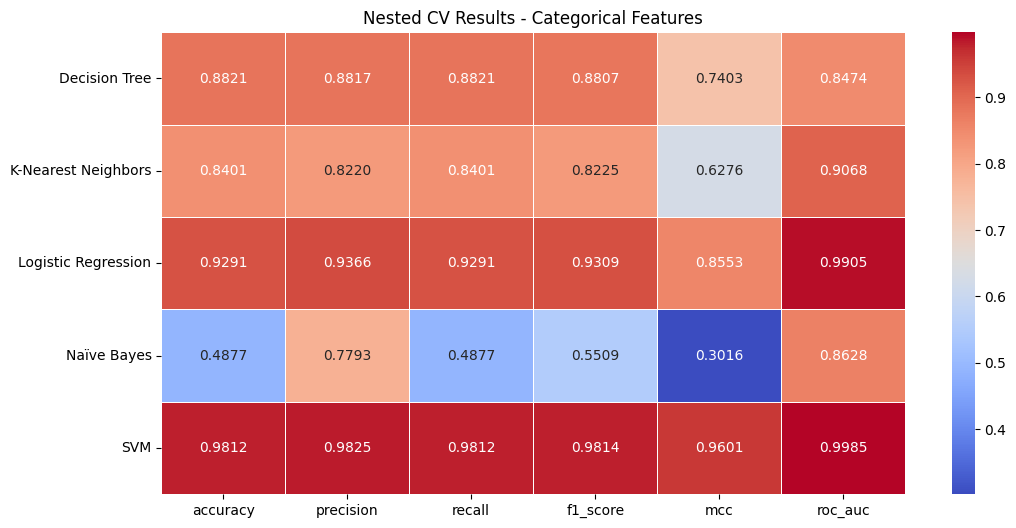

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns


numeric_results_df = pd.DataFrame(numeric_results).T
categorical_results_df = pd.DataFrame(categorical_results).T

# Heatmap for Numeric Features
plt.figure(figsize=(12, 6))
sns.heatmap(numeric_results_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.title("Nested CV Results - Numeric Features")
plt.show()

# Heatmap for Categorical Features
plt.figure(figsize=(12, 6))
sns.heatmap(categorical_results_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.title("Nested CV Results - Categorical Features")
plt.show()



## Analysis of Nested CV Results (Heatmap Visualization)

### Numeric Features (Top Heatmap)

##### Top-Performing Model: SVM (Support Vector Machine)

- Accuracy, Precision, Recall, F1-Score: All around 0.9790, which is very close to perfect classification.
- MCC (Matthews Correlation Coefficient): 0.9541—Indicates excellent performance even with imbalanced classes.
- ROC AUC: 0.9992 — A nearly perfect classifier based on ROC curve performance.

###### Runner-Up: Decision Tree

- Performs consistently well across all metrics with scores around 0.97.
- MCC (0.9413) and ROC AUC (0.9661) are slightly lower than SVM, suggesting a small drop in overall robustness compared to SVM.
- Underperforming Models: Naive Bayes & Logistic Regression

###### Naive Bayes has the lowest scores across all metrics, with an MCC of 0.4002 and ROC AUC of 0.8991, indicating poor class separation.

###### Logistic Regression shows moderate performance, especially weaker in terms of MCC (0.6373) and ROC AUC (0.9399), suggesting limited predictive capability for non-linear data patterns.

### Categorical Features (Bottom Heatmap)

##### Top-Performing Model: SVM

- Maintains its superior performance with scores around 0.9790 for accuracy, precision, recall, and F1-score.
- MCC: 0.9551, showing excellent predictive capability even for multi-class data.
- ROC AUC: 0.9987, only slightly lower than numeric features, indicating high generalization performance.

##### Runner-Up: Logistic Regression

- Performs surprisingly well on categorical data with scores around 0.93.
- MCC (0.8512) and ROC AUC (0.9905) are significantly better than in the numeric case, suggesting categorical encoding suits this model better.
- Underperforming Models: Naive Bayes & K-Nearest Neighbors

##### Naive Bayes has very low scores across the board, especially the MCC (0.3016) and ROC AUC (0.8628), indicating it struggles significantly with categorical encodings.
##### K-Nearest Neighbors (KNN) also underperforms with an MCC of 0.5690 and ROC AUC of 0.8652.

In [11]:
# Learning Curve Plot Function
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=outer_kf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring="accuracy"
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()



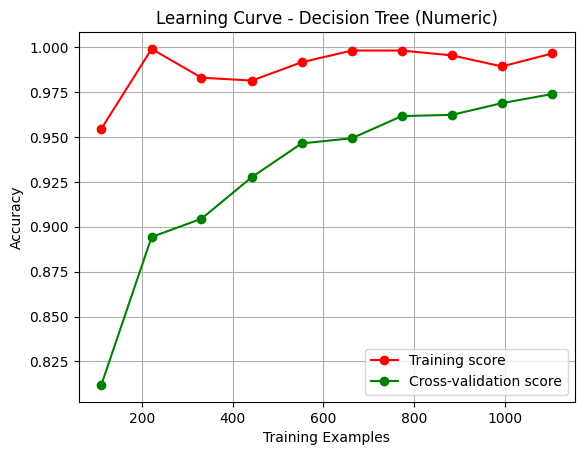

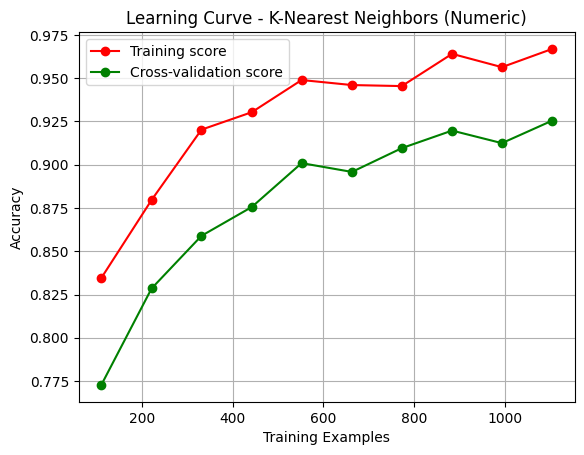

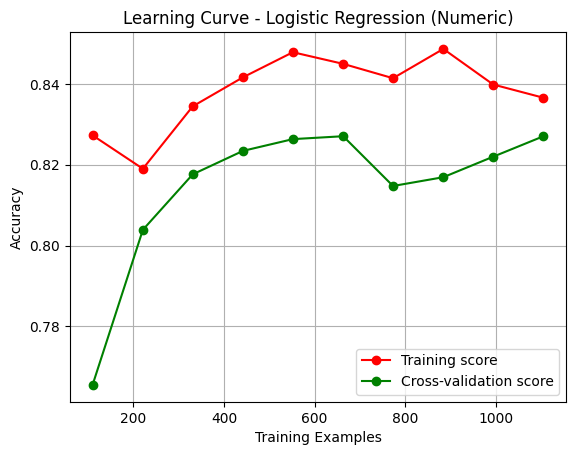

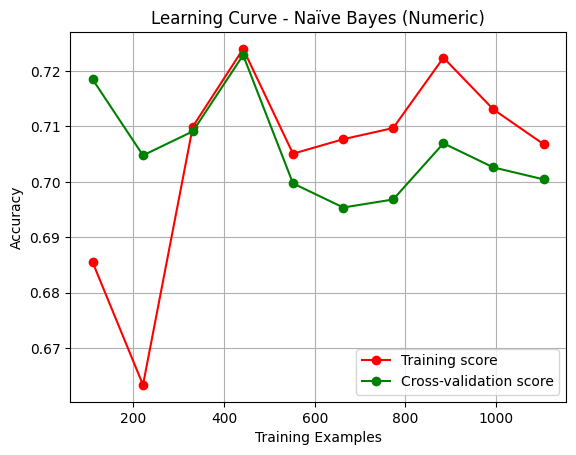

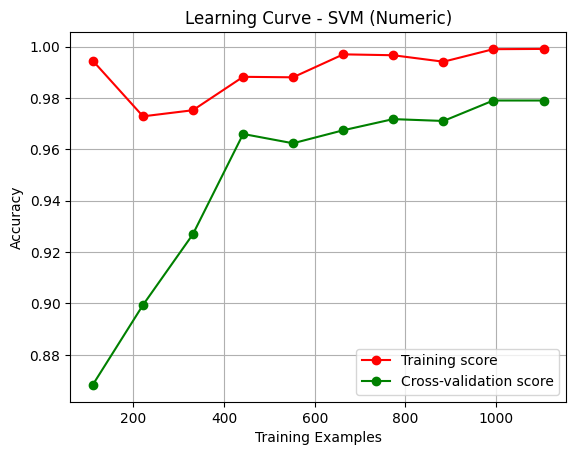

In [12]:
# Plot Learning Curves for Numeric Models
for model_name, model in numeric_best_models.items():
    plot_learning_curve(model, X_train_num, y_train, f"Learning Curve - {model_name} (Numeric)")

### Overall Recommendations:

#### Best Model:
- SVM consistently outperforms other models across all training sizes with high validation accuracy and generalization.

#### Runner-Up:
- Decision Tree shows strong performance but overfits the training data. Pruning or limiting max_depth could reduce overfitting.

#### Avoid Using:
- Naive Bayes and Logistic Regression show clear signs of underfitting and low generalization potential.


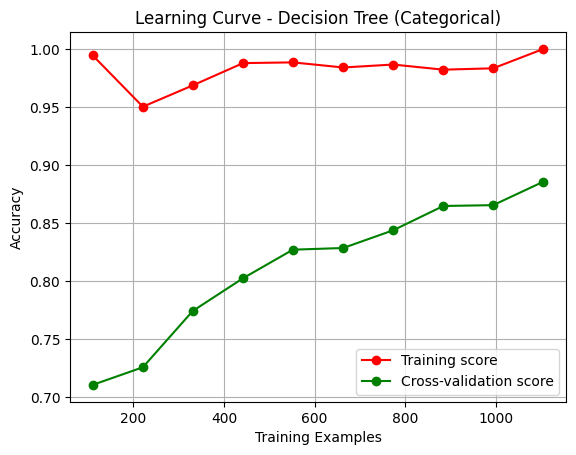

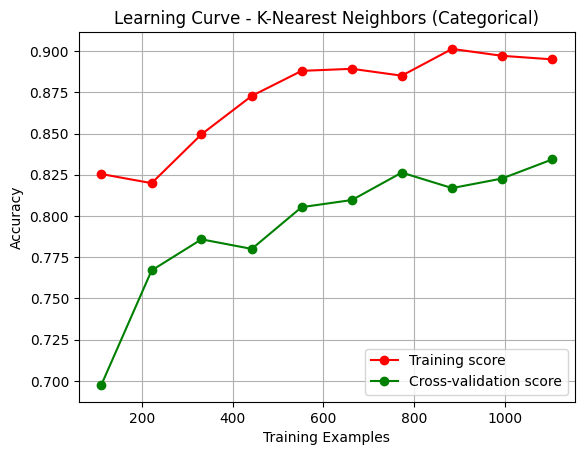

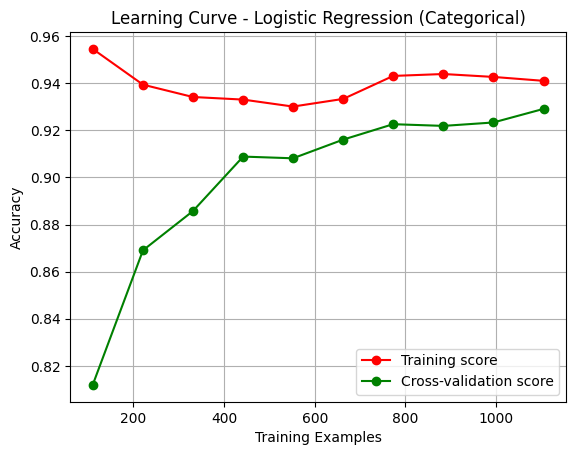

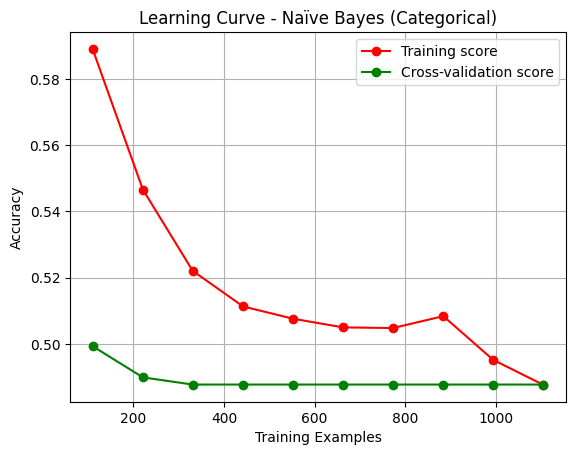

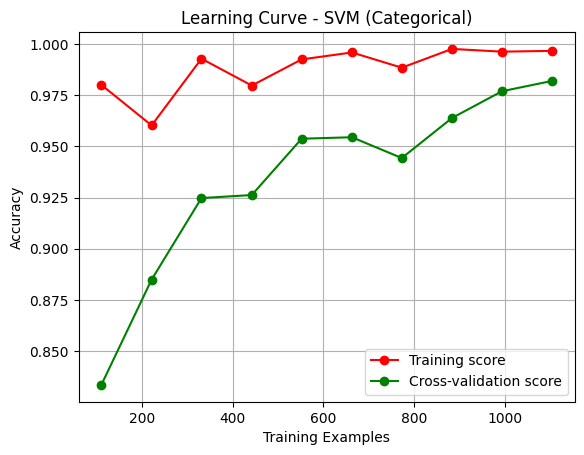

In [13]:
# Plot Learning Curves for Categorical Models
for model_name, model in categorical_best_models.items():
    plot_learning_curve(model, X_train_cat, y_train, f"Learning Curve - {model_name} (Categorical)")


#### Best Model: SVM (Categorical)
- Consistently achieves high training and validation scores (above 0.97).
- Shows excellent generalization with a narrow gap between training and cross-validation curves as the data increases.

### Best model: SVM (Numeric + Categorical)

#### Next steps:

1. Train SVM on the same 80% split to get the best hyperparameters
2. Test it on 20% data (kept aside)

#### Train the Best SVM Model on Full Training Set (80%)

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Define hyperparameter grid for SVM
svm_param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto"]
}

# Initialize SVM model
svm_model = SVC(probability=True, random_state=42, class_weight="balanced")


grid_search_numeric = GridSearchCV(
    svm_model,
    svm_param_grid,
    cv=5,  
    scoring="accuracy",
    n_jobs=-1
)


grid_search_numeric.fit(X_train_num, y_train)
best_svm_numeric = grid_search_numeric.best_estimator_

# Best hyperparameters found
print("Best Hyperparameters for SVM (Numeric Features):", grid_search_numeric.best_params_)


Best Hyperparameters for SVM (Numeric Features): {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


In [16]:
# using the 80% training data (Categorical Features)
grid_search_categorical = GridSearchCV(
    svm_model,
    svm_param_grid,
    cv=5,  # 5-Fold Cross-Validation
    scoring="accuracy",
    n_jobs=-1
)


grid_search_categorical.fit(X_train_cat, y_train)
best_svm_categorical = grid_search_categorical.best_estimator_

# Display the best hyperparameters found
print("Best Hyperparameters for SVM (Categorical Features):", grid_search_categorical.best_params_)


Best Hyperparameters for SVM (Categorical Features): {'C': 100, 'gamma': 'scale', 'kernel': 'poly'}


In [17]:
# Train the best model with optimal hyperparameters on the full 80% training data
best_svm_numeric.fit(X_train_num, y_train)

# Predict on the held-out 20% test set
y_pred_numeric = best_svm_numeric.predict(X_test_num)

# Evaluation Metrics
print("\nFinal Evaluation on Numeric Features (20% Test Data):\n")
print(classification_report(y_test, y_pred_numeric))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_numeric))



Final Evaluation on Numeric Features (20% Test Data):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Confusion Matrix:
 [[ 77   0   0   0]
 [  0  14   0   0]
 [  0   0 242   0]
 [  0   0   0  13]]


In [18]:
# Train the best model with optimal hyperparameters on the full 80% training data
best_svm_categorical.fit(X_train_cat, y_train)

# Predict on the held-out 20% test set
y_pred_categorical = best_svm_categorical.predict(X_test_cat)

# Evaluation Metrics
print("\nFinal Evaluation on Categorical Features (20% Test Data):\n")
print(classification_report(y_test, y_pred_categorical))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_categorical))



Final Evaluation on Categorical Features (20% Test Data):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        77
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00       242
           3       1.00      1.00      1.00        13

    accuracy                           1.00       346
   macro avg       1.00      1.00      1.00       346
weighted avg       1.00      1.00      1.00       346

Confusion Matrix:
 [[ 77   0   0   0]
 [  0  14   0   0]
 [  0   0 242   0]
 [  0   0   0  13]]


### Conclusions:

#### Overfitting Possibility:
- Achieving a perfect score could mean:
- The dataset might be too easy for the model due to highly separable classes.
- The dataset could be imbalanced but with patterns that are easy to distinguish.

#### Class Imbalance:
- Classes 1 and 3 have significantly fewer instances compared to Class 2.

### Categorical vs. Numeric Data for Car Evaluation

##### Conclusion: 
#### Categorical Makes Sense
- The features represent distinct qualitative categories, not measurable quantities.
